# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В работе мы построим модель для определения стоимости.

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Сервису, как заказчику, важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт библиотек

Перед началом исследования импортируем необходимые библиотеки, а также модели.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import scale
from sklearn.preprocessing import OrdinalEncoder



from catboost import CatBoostRegressor
from sklearn.tree import  DecisionTreeRegressor
from lightgbm import LGBMRegressor


### Обзор данных

In [2]:
data = pd.read_csv('autos.csv') # загружаем датасет в переменную data

In [3]:
data.head(10)                   # первые 10 строчек 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


В датасете 15 столбцов (признаков):

- `DateCrawled` — дата, когда анкета скачена из базы;
- `Price` — цена продажи — целевой признак;
- `VehicleType` — тип автомобильного кузова;
- `RegistrationYear`— год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` — мощность в лошадиных силах;
- `Model` — модель машины;
- `Kilometer` — пробег в км;
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип топлива;
- `Brand` — марка автомобиля;
- `NotRepaired` — была машина в ремонте или нет;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий;
- `PostalCode` — почтовый индекс владельца автомобиля;
- `LastSeen` — дата последней активности пользователя.



In [4]:
data.info()                          #общая информация по датасету

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датасете более 350 000 объектов — достаточно большой объем. В некоторых столбцах-признаках имеются пропуски. Кроме того, много признаков являются категориальными — понадобится приобразовать их в численные для обучения моделей.

In [5]:
data.describe() #агрегированные данные по численным признакам

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Из агрегированных данных видно, что в столбце `Price` минимальное значение равно 0 — потребуется далее рассмотреть данные объекты. Интересные минимумы и максимумы в `RegistrationYear` и `Power`. Признак `NumberOfPictures` судя по всему был выгружен с ошибкой — он пустой. 

### Проверка на явные дубликаты

In [6]:
data.duplicated().sum()

4

Незначительное количество объектов в датасете задублированно — их стоит удалить, чтобы модель не переобучилась.


In [7]:
data = data.drop_duplicates()

### Удаление неинформативных признаков

От даты выгрузки анкеты конечная цена автомобиля не зависит — этот признак не является информативным и его можно удалить.

In [8]:
data = data.drop(columns=['DateCrawled'])

Формально и дата, когда объявление о продаже было опубликовано, не должна влиять на цену автомобиля. Однако, если в датасете присутствуют объявления за разные годы, то на цене может сказаться инфляция. Проверим за какой период мы имеем объявления.

In [9]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S') # меняем тип данных
                                                                                      # для удобства обработки

In [10]:
data['DateCreated'].dt.year.value_counts()                                            # посчитаем количесвто объектов по годам

2016    354339
2015        25
2014         1
Name: DateCreated, dtype: int64

В датасете всего 26 объектов не за 2016 год. Посмотрим на них:

In [11]:
data[data['DateCreated'].dt.year == 2014]                                             # выводим единственный объект за 2014 год

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
61207,8999,NaN,2005,NaN,0,147,125000,0,petrol,alfa_romeo,NaN,2014-03-10,0,79669,2016-04-07 04:46:24


**Alfa Romeo** не самая популярная машина на рынке — а марка определенно влияет на цену. Если модель поймет это, пробуя спрогнозировать цену для итальнцев по цене 2014 года, точно ошибемся с прогнозом:

In [12]:
data[data['Brand']== 'alfa_romeo']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
80,250,wagon,2000,manual,155,156,150000,0,petrol,alfa_romeo,yes,2016-04-01,0,8396,2016-04-05 20:18:14
138,3450,sedan,2007,manual,120,147,150000,4,gasoline,alfa_romeo,no,2016-04-02,0,86678,2016-04-04 07:51:11
412,13950,other,2011,manual,140,NaN,60000,11,gasoline,alfa_romeo,no,2016-03-26,0,86830,2016-04-06 14:15:39
422,3200,convertible,2001,manual,150,spider,150000,6,NaN,alfa_romeo,NaN,2016-03-21,0,24939,2016-03-31 08:18:09
474,2990,sedan,2006,manual,105,147,150000,6,petrol,alfa_romeo,no,2016-03-30,0,74912,2016-04-07 09:44:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353947,3800,sedan,2003,manual,166,156,125000,7,petrol,alfa_romeo,no,2016-04-03,0,50827,2016-04-05 17:45:54
353953,1450,wagon,2005,manual,175,156,150000,7,gasoline,alfa_romeo,no,2016-03-05,0,97082,2016-03-17 05:15:16
354102,3950,coupe,2006,manual,166,other,150000,5,petrol,alfa_romeo,no,2016-03-19,0,59174,2016-03-29 03:15:54
354105,750,sedan,1998,manual,190,156,150000,10,petrol,alfa_romeo,no,2016-03-31,0,27568,2016-04-06 13:15:43


Из 15 объектов один будет выбросом.

In [13]:
data[data['DateCreated'].dt.year == 2015]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
4001,6000,bus,1995,auto,200,other,150000,0,petrol,chevrolet,no,2015-03-20,0,24558,2016-04-07 03:45:01
9972,3490,sedan,2006,manual,88,clio,150000,3,petrol,renault,no,2015-11-02,0,40880,2016-03-17 15:46:57
29712,6950,sedan,2004,auto,150,a3,100000,1,petrol,audi,no,2015-12-06,0,61389,2016-04-06 14:16:09
60168,5999,sedan,1997,auto,197,c_klasse,150000,9,petrol,mercedes_benz,no,2015-11-17,0,28816,2016-04-06 05:46:03
75598,600,small,2005,manual,54,polo,150000,1,petrol,volkswagen,yes,2015-09-04,0,72669,2016-03-15 14:16:58
75684,5400,small,2009,manual,44,ypsilon,40000,9,petrol,lancia,no,2015-11-12,0,53119,2016-04-06 03:16:57
76459,7500,sedan,2002,auto,333,7er,150000,9,lpg,bmw,no,2015-12-27,0,46117,2016-03-27 22:15:37
77378,7999,sedan,2013,manual,75,mii,30000,6,petrol,seat,no,2015-11-24,0,60437,2016-04-05 22:47:33
85505,900,sedan,1997,auto,115,impreza,150000,4,petrol,subaru,no,2015-12-05,0,2943,2016-03-22 23:16:25
86601,14250,convertible,2005,manual,163,slk,150000,6,petrol,mercedes_benz,no,2015-08-07,0,76228,2016-04-07 09:15:23


Большинство имеющихся объявлений за 2015 год созданы в ноябре или декабре и должны уже учитывать инфляцию за первые кварталы года, однако, т.к. они составляют незначительное долю от общего датасета (`25 / 354 335 = 0,00007 %`) их можно удалить.

In [14]:
data = data[data['DateCreated'].dt.year == 2016]    # оставляем объекты за 2016 год
data = data.drop(columns=['DateCreated'])           # а после удаляем столбец с датой создания объявления

Интересный вопрос, влияет ли месяц регистрации транспортного средства на его цену — формально его "новизну" определяет пробег, а не дата регистрации, но в зависимости от месяца мы можем предполагать поколение популярных моделей — а это точно ценообразующий фактор. Например, **Mitsubishi Outlander III поколения** выпускался с 2012 по сентябрь 2014, а в октябре была представлена версия **рестайлинг** — изменились передние и задние бампера, решётка радиатора, появились расширители арок, поменялась задняя оптика, появились светодиоды и новые 18-дюймовые колёсные диски, улучшилась шумоизоляция салона, система охлаждения вариатора, была перенастроена подвеска.

Ранее мы заметили ошибку в признаке `NumberOfPictures` — все квартили и максимум равнялись нулю. Проверим заполнение признака, посчитав уникальные значения в столбце.

In [15]:
data['NumberOfPictures'].value_counts()

0    354339
Name: NumberOfPictures, dtype: int64

Этот признак, а также информацию об авторе объявления (`PostalCode` и `LastSeen`) мы удалим, так как они не влияют на цену транспортного средства.

In [16]:
data = data.drop(columns=['NumberOfPictures','PostalCode','LastSeen'])

Посмотрим на информацию по датасету после удаления неинформативных столбцов

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354339 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354339 non-null  int64 
 1   VehicleType        316851 non-null  object
 2   RegistrationYear   354339 non-null  int64 
 3   Gearbox            334508 non-null  object
 4   Power              354339 non-null  int64 
 5   Model              334635 non-null  object
 6   Kilometer          354339 non-null  int64 
 7   RegistrationMonth  354339 non-null  int64 
 8   FuelType           321444 non-null  object
 9   Brand              354339 non-null  object
 10  NotRepaired        283189 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


Т. о. у нас осталось 11 признаков (один из которых целевой).

### Обработка пропусков и аномалий

#### Аномалии в целевом признаке

В начале исследования мы заметили, что целевой признак `Price` имеет минимальное значение 0. Посмотрим на распределение значений этого признака:

<AxesSubplot:>

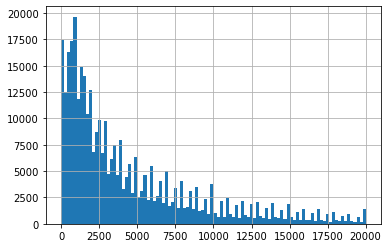

In [18]:
data['Price'].hist(bins=100)

Кажется, большинство автомобилей в датасете достаточно дешевые — пик распределения цены где-то около 1000 евро (при этом среднее равняется 4416, а медиана — 2700).

Посмотрим на автомобили без указания цены:

In [19]:
data[data['Price']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10772 entries, 7 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Price              10772 non-null  int64 
 1   VehicleType        7032 non-null   object
 2   RegistrationYear   10772 non-null  int64 
 3   Gearbox            8294 non-null   object
 4   Power              10772 non-null  int64 
 5   Model              8588 non-null   object
 6   Kilometer          10772 non-null  int64 
 7   RegistrationMonth  10772 non-null  int64 
 8   FuelType           7336 non-null   object
 9   Brand              10772 non-null  object
 10  NotRepaired        5484 non-null   object
dtypes: int64(5), object(6)
memory usage: 1009.9+ KB


In [20]:
data[data['Price']==0].head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes
154,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,NaN
231,0,wagon,2001,manual,115,mondeo,150000,0,NaN,ford,NaN
334,0,NaN,2005,NaN,0,polo,150000,0,petrol,volkswagen,NaN
415,0,NaN,1985,NaN,0,3er,150000,0,NaN,bmw,NaN
466,0,NaN,2016,auto,197,3er,150000,12,gasoline,bmw,no


Почти 11 000 объектов — возможно это автомобили на разборке, продающиеся на запчасти, возможно автомобили на заказ, которые "пригонят" из другой страны (у 2200 не указана конкретная марка), возможно, авторы объявления оставили цену открытой для торга. Так или иначе, обучить по ним модель и предсказать цену для новых объявлений не получится — **удалим эти объекты из датасета**.

In [21]:
data = data[data['Price']!=0]

#### Аномалии в годе регистрации ТС

<AxesSubplot:>

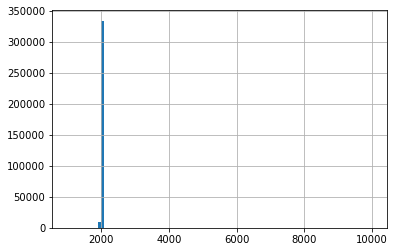

In [22]:
data['RegistrationYear'].hist(bins=100)

График делают непригодным аномальные значения — минимум составляет 1000 год, а максимум 9999. Нормальными очевидно могут является годы с 1908 (появление первого массового автомобиля Ford T — хотя вряд ли такие старые машины есть в датасете) по 2016 (т.к. все анкеты опубликованы в 2016).

In [23]:
data = data[data['RegistrationYear'] > 1908]# отбрасываем значения с годом регистрации меньше адекватного

Автомобили, с датой регистрации позже выгрузки датасета, следует сначала рассмотреть — возможно это предпродажа будущих моделей.

In [24]:
data[data['RegistrationYear'] > 2016].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,13779.000000,13779.000000,13779.000000,13779.000000,13779.000000
mean,3324.007185,2043.060091,89.073735,131936.642717,4.807969
std,3470.907197,384.355937,252.706240,36573.752919,3.994933
min,1.000000,2017.000000,0.000000,5000.000000,0.000000
25%,1050.000000,2017.000000,0.000000,125000.000000,1.000000
50%,2000.000000,2017.000000,80.000000,150000.000000,4.000000
75%,4250.000000,2018.000000,117.000000,150000.000000,8.000000
max,20000.000000,9999.000000,16011.000000,150000.000000,12.000000


Вероятно, часть объектов действительно относится к такого рода объявлениям, однако средняя цена 3324 евро явно меньше цены нового автомобиля. Т.к. возможности рассматривать каждое из 13779 объявления в ручную нет возможности, признаем такие объекты аномальными и также отбросим их.

In [25]:
data = data[data['RegistrationYear'] <= 2016]

<AxesSubplot:>

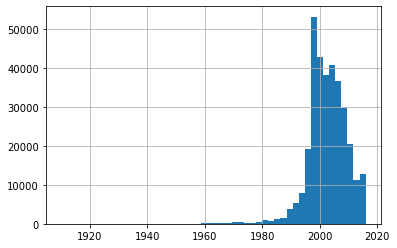

In [26]:
data['RegistrationYear'].hist(bins=50) # распределение после удаления аномалий

#### Пропуски и аномалии в типах автомобильного кузова

Сначала посмотрим какие значения имеюся по данному признаку:

In [27]:
data['VehicleType'].value_counts()

sedan          89389
small          78009
wagon          63694
bus            28341
convertible    19860
coupe          15632
suv            11790
other           3085
Name: VehicleType, dtype: int64

Нетипичных значений и смысловых синонимов нет. Теперь перейдем к пропускам:

In [28]:
data['VehicleType'].isna().sum()

19935

Т. к. одна и та же модель может выпускать в разных типах кузова, заменить пропуски по названию модели не получится.

<AxesSubplot:>

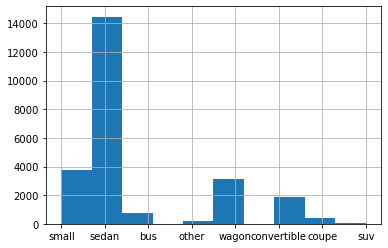

In [29]:
data[data['Model']=='golf']['VehicleType'].hist() #распределение типов кузова для гольфов

Чтобы при дальнейшей обработке данных не потерять строки с пропусками заменим `NaN` на новое значение **undefined**

In [30]:
data['VehicleType'] = data['VehicleType'].fillna('undefined')

#### Обработка пропусков и аномалий по коробкам передач

In [31]:
data['Gearbox'].value_counts()

manual    251144
auto       62991
Name: Gearbox, dtype: int64

В датасете представлено два типа значений для коробки передач - коробки автомат не делятся на типы (автомат, робот, вариатор).

In [32]:
data.pivot_table(index=['Gearbox'],
                 values=['Price'],
                 aggfunc=['mean'])

,mean
,Price
Gearbox,
auto,7048.216031
manual,4123.514458


Тип коробки передач сильно влияет на цену автомобиля ("автоматы" дороже). Можно попробовать "восстановить" пропуски, сравнив цену со средней для марки текущего года - если она ближе к цене "механики" заполнить "manual", а если к цене "автомата" — "auto".

In [33]:
data.pivot_table(index=['Gearbox'],
                 columns=['Model','RegistrationYear'],
                 values=['Price'],
                 aggfunc=['mean'])

mean                                               \
                   Price                                                
Model                100                                                
RegistrationYear    1970    1972         1973    1974    1975    1976   
Gearbox                                                                 
auto              2800.0     NaN          NaN     NaN     NaN     NaN   
manual               NaN  7530.0  4463.333333  7000.0  3650.0  4224.5   

                                                   ...               \
                                                   ...                
Model                                              ...       zafira   
RegistrationYear     1978   1979     1980    1982  ...         2007   
Gearbox                                            ...                
auto               2999.0    NaN  15000.0  8000.0  ...  5644.080000   
manual            14950.0  850.0   6500.0  2900.0  ...  5300.467456   

                                                                      \
                                                                       
Model                                                                  
RegistrationYear         2008         2009         2010         2011   
Gearbox                                                                
auto              6142.483871  6360.571429  9018.888889          NaN   
manual            6498.340206  6973.151515  9241.521739  9152.757143   

                                                                     \
                                                                      
Model                                                                 
RegistrationYear          2012          2013     2014          2015   
Gearbox                                                               
auto              14950.000000  16925.000000      NaN           NaN   
manual            11401.814815  13203.333333  14902.9  15466.666667   

                               
                               
Model                          
RegistrationYear         2016  
Gearbox                        
auto              1275.000000  
manual            2918.366197  

[2 rows x 4573 columns]

С такой логикой возникли проблемы — для некоторых моделей нет данных по цене за определенные годы, а на примере "zafira" мы видим, что цена может и почти не отличаться (у моделей 2008,2009,2010 годов с разными коробками почти одинаковая цена)

Поступим с пропусками в признаке "Gearbox" аналогично пропускам в "VehicleType" — **заменим пропуски на новое значение undefined**, чтобы объекты с пропусками не потерялись при дальнейшей обработке и группировках.

In [34]:
data['Gearbox'] = data['Gearbox'].fillna('undefined')

#### Пропуски и аналомалии по мощности двигателя.

Известное выражение (то ли Генри Форда, то ли Энзо Феррари) — "лошадиные силы продают автомобиль, а крутящий момент выигрывает гонки". Мощность двигателя действительно влияет на цену автомобиля. Посмотрим на распределение по этому параметру.

<AxesSubplot:>

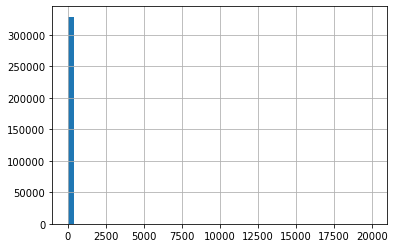

In [35]:
data['Power'].hist(bins=50)

График получается неинформативным. При среднем значении в 110 л.с. в датасете есть объекты со значением в 20 000 л.с.

В качестве границы нормальных значений установим 1000 л.с. — хотя сегодня есть суперкары и по 1500 л.с. такие объекты не будут типичными.

In [36]:
data = data[data['Power'] <= 1000]

<AxesSubplot:>

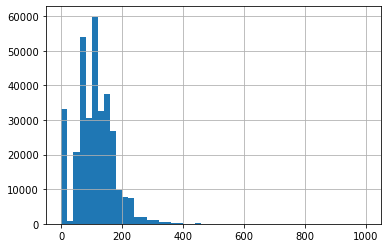

In [37]:
data['Power'].hist(bins=50)

График растянут вправо из-за сохранившихся крайних значений. Однако, уже после примерно 600 л.с. мы не видим рисунка диаграммы из-за незначительного количества объектов.

In [38]:
data[data['Power'] > 600] #посмотрим на объекты

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
4060,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no
6296,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,NaN
6637,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes
8057,500,small,2002,manual,620,ypsilon,150000,12,petrol,lancia,NaN
...,...,...,...,...,...,...,...,...,...,...,...
317353,3999,small,2009,manual,682,NaN,70000,1,petrol,peugeot,no
320442,3400,small,2007,undefined,732,NaN,125000,12,petrol,citroen,no
328668,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes
331252,4600,small,2008,manual,601,polo,80000,1,petrol,volkswagen,no


Никаких суперкаров — chevrolet matiz c 600 л.с. (при стоке 52 л.с.), volkswagen polo с 601 л.с. — объявления больше похожи на ошибочные или мошеннические. Удалим их как аномалии. Граница в 600 л.с. позволит оставить в датасете настоящие суперкары (например, Ford Mustang GT).

В качестве левой границы установим 20 л.с. — такую мощность имел уже упоминаемый нами Ford T.

<AxesSubplot:>

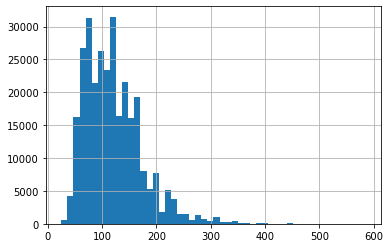

In [39]:
#отбрасываем крайние значения и смотрим на новое распределение

data = data[(data['Power'] > 24)&(data['Power'] < 600)]
data['Power'].hist(bins=50)  

#### Проверка значений по признаку `Model`

В датасете имеются пропуски по признаку `Model`. Восстановить их не представляется возможным, а модель — важнейший ценообразующий фактор — модели одного бренда могут быть несопоставимы по стоимости (например, Ford Focus и Ford Mustang).

По этой причине, объекты с пропусками придется отбросить.

In [40]:
data.dropna(subset=['Model'], inplace=True)

#### Проверка пробега 

In [41]:
data['Kilometer'].isna().sum() #проверка пропусков

0

<AxesSubplot:>

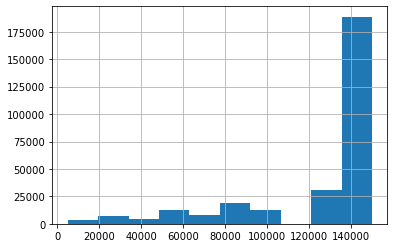

In [42]:
data['Kilometer'].hist(bins=10) 

Кажется, аномалий нет — за исключением почти отсутствующих значений с промежутке 105 000 - 120 000. В датасете преобладают старые "тачки" и для них характерен большой пробег — как раз такую картину мы и видим.

#### Обработка признака Brand

Сначала проверим датасет на наличие неявных дубликатов (например, если автор объявления опечатался):

In [43]:
data.Brand.value_counts()

volkswagen       62045
opel             31390
bmw              31150
mercedes_benz    26687
audi             24881
ford             20148
renault          13500
peugeot           8894
fiat              7315
seat              5720
skoda             4865
mazda             4530
smart             4347
citroen           4108
nissan            3924
toyota            3913
hyundai           2987
mini              2927
volvo             2753
mitsubishi        2396
honda             2274
kia               2014
alfa_romeo        1905
suzuki            1891
chevrolet         1396
chrysler          1116
dacia              787
subaru             622
porsche            610
daihatsu           600
jeep               563
saab               464
land_rover         454
jaguar             431
daewoo             385
lancia             364
rover              322
trabant            241
lada               151
Name: Brand, dtype: int64

Неявные дубликаты не выявлены.
Теперь посмотрим на график цены по брендам.

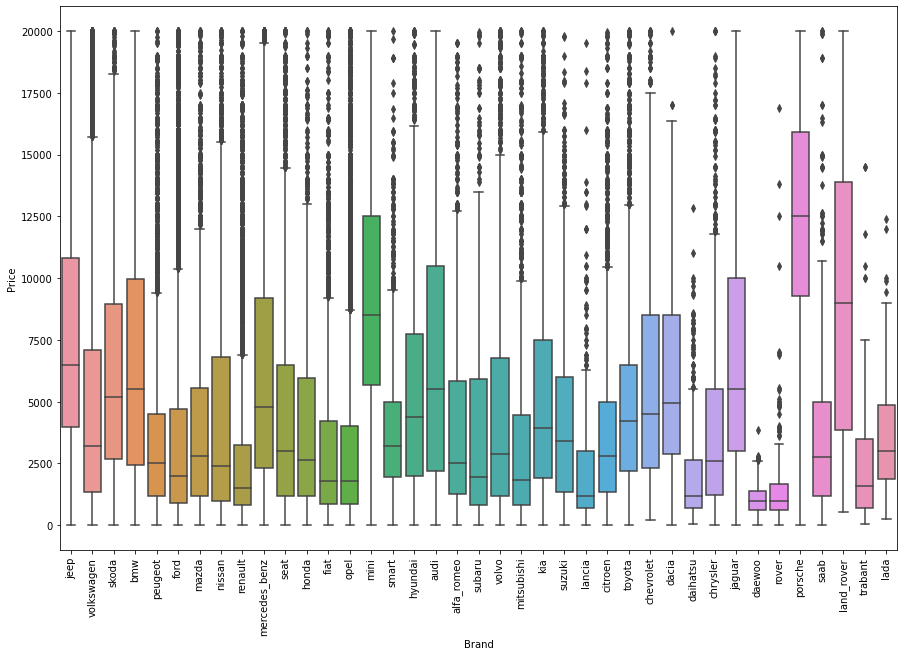

In [44]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=data, x='Brand', y='Price')
plt.xticks(rotation=90)
plt.show()

Разброс цен большой — у многих брендов имеется значительно количество "выбросов", которые продавались дороже рынка. Что важно — мы не наблюдаем дорогих daewoo, lada и daihatsu, и видим дорогие porsche и land rover'ы, что кажется логичным.

#### Обработка признака `FuelType`

In [45]:
data.FuelType.value_counts()

petrol      181138
gasoline     85894
lpg           4418
cng            467
hybrid         180
other           67
electric        36
Name: FuelType, dtype: int64

Помимо традионных бензина и дизеля в датасете еще имеются электрокары, гибриды и машины на газу несольких типов.

1.CNG (Compressed Natural Gas) – сжатый природный газ (метан): газообразные углеводороды, образующиеся в земной коре, высокоэкономичное энергетическое топливо.

2.LPG (Liquified Petroleum Gas) – сжиженный газ (пропан-бутан). Газ, полученный при добыче и переработке нефти. В жидкое состояние переводят при охлаждении до критической температуры и последующей конденсации в результате отвода теплоты парообразования.


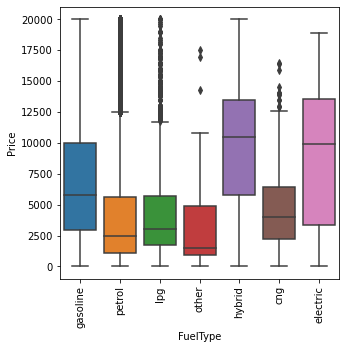

In [46]:
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(data=data, x='FuelType', y='Price')
plt.xticks(rotation=90)
plt.show()

Видно, что гибриды и электрокары как правило дороже — это наши нового поколения. Взглянем на пропуски по признаку:

In [47]:
data.FuelType.isna().sum()

12870

Заполним пропуски уже имеющимся значение `other` — так мы не потеряем объекты.

In [48]:
data['FuelType'] = data['FuelType'].fillna('other')

#### Обработка признака "NotRepaired"

Последний оставшийся признак `NotRepaired` — была ли машина в ремонте.

In [49]:
data.NotRepaired.value_counts() #значения

no     218533
yes     27424
Name: NotRepaired, dtype: int64

In [50]:
data.NotRepaired.isna().sum() #количество пропусков

39113

Почти у 40 тысяч оставшихся объектов нет информации, была ли машина в ремонте, — это большая доля датасета. Заменим признак для новых машин (до 3 лет) на `no`, и для более старых на `yes`. Для этого напишем функцию.

In [51]:
def get_repaired(row):
    """
    Функция проверит год регистрации автомобиля. Если автомобиль зарегистирован до 2013 года и нет информации о ремонте,
    мы предположим, что автомобиль уже был отремонтирован в силу возраста.Если автомобиль не старше 3 лет (предполагается,
    что объекты в датасете датируются 2016 годом), и нет информации о ремонте, то мы предположим, что в ремонте он не был.
    
    Новый признак получит булев тип.
    """
    
    if row['RegistrationYear'] <= 2013:
        if row['NotRepaired'] == 'no':
            return False
        elif row['NotRepaired'] == 'yes':
            return True
        else:
            return True
    else:
        if row['NotRepaired'] == 'no':
            return False
        elif row['NotRepaired'] == 'yes':
            return True
        else:
            return False
        

In [52]:
data['WasRepaired'] = data.apply(get_repaired, axis=1) # создаем новый признак WasRepaired с булевым типом
                                                       # на основе признака NotRepaired

In [53]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,WasRepaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,True
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,False
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,False
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,True
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,False


In [54]:
data = data.drop(columns=['NotRepaired']) #удаляем дублирующий признак

#### Проверка корреляций:

Посмотрим на наличие корреляций, между оставшимися признаками — возможно, есть линейная зависимость между признаками и какие-то являются избыточными

Text(0.5, 1.0, 'Корреляции признаков')

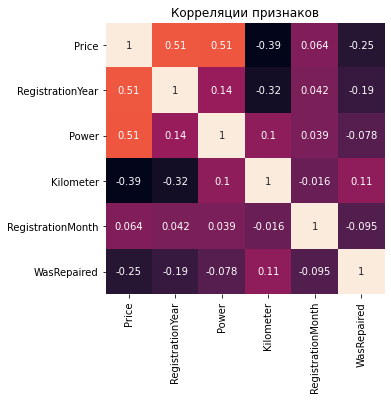

In [55]:
fig = plt.figure(figsize=(5,5))


sns.heatmap(data.corr(),
            annot = True,
            cbar=False)
plt.title('Корреляции признаков')

Как мы видим, больший вклад в цену дает год регистрации автомобиля и мощность двигателя. Большую роль играет пробег автомобиля. 

### Выводы по разделу

На этапе предобработки данных были последовательно изучены и обработаны все признаки в датасете:
- был удален неинформативный признак с датой выгрузки анкеты;
- были отброшены объявления до 2016 года, с целью предотвратить влияние инфляции на прогнозируемый признак;
- удален выгруженный с ошибкой признак с количеством изображений в объявлении;
- обработаны аномалии в целевом признаке — уделаны объявления с нулевым значением цены;
- удалены объекты с датой регистрации ТС позже 2016 года;
- заполнены пропуски в признаках "Тип кузова"  и "Тип коробки передач";
- удалены объявления с аномальными значениями мощности двигателя;
- удалены объявления с отсутствующей маркой автомобиля;
- произвеена проверка пробега автомобилей;
- заменены пропуски в признаке "FuelType";
- преобразован тип данных и обработаны пропуски в признаке "NotReaired"

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285070 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              285070 non-null  int64 
 1   VehicleType        285070 non-null  object
 2   RegistrationYear   285070 non-null  int64 
 3   Gearbox            285070 non-null  object
 4   Power              285070 non-null  int64 
 5   Model              285070 non-null  object
 6   Kilometer          285070 non-null  int64 
 7   RegistrationMonth  285070 non-null  int64 
 8   FuelType           285070 non-null  object
 9   Brand              285070 non-null  object
 10  WasRepaired        285070 non-null  bool  
dtypes: bool(1), int64(5), object(5)
memory usage: 32.3+ MB


In [57]:
data = data.reset_index(drop=True) # перезапишем датасет с исправленной индексацией

После предобработки данных количество объектов в датасете сократилось почти на 20% с 354366 до 285070. Количество признаков уменьшено с 16 до 11, а использование памяти — с 43,3+ до 32,3+

## Обучение моделей

### Разделение датасета на выборки

In [58]:
target = data['Price']                          # определяем целевой признак
features = data.drop('Price', axis=1)          

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features,
                                                                                        target,
                                                                                        test_size=0.4,
                                                                                        random_state=1049)


In [59]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,
                                                                            target_valid_test,
                                                                            test_size=0.5,
                                                                            random_state=1049)

In [60]:
features_valid.shape

(57014, 10)

In [61]:
target_valid.shape

(57014,)

### Обучение модели решающего древа

Перед обучением моделей с применение бустинга, обучим регрессор по алгоритму решающего древа. Т.к. в датасете имеются категориальные признаки перед обучение модели применим технику порядкового кодирования.

In [62]:
cat_features=['VehicleType','Gearbox','FuelType','Brand','Model'] #определяем категориальные признаки

In [63]:
encoder = OrdinalEncoder()

ord_features = data.drop('Price', axis=1) .copy()

ord_features[cat_features] = encoder.fit_transform(data[cat_features]) 


In [64]:
ord_features_train = ord_features.loc[features_train.index, :]
ord_features_valid = ord_features.loc[features_valid.index, :]
ord_features_test = ord_features.loc[features_test.index, :]
    

In [65]:
ord_features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,WasRepaired
83615,8.0,2007,1.0,163,11.0,150000,5,2.0,2.0,False
278144,5.0,2007,1.0,54,173.0,60000,5,6.0,37.0,False
109362,7.0,2000,1.0,125,28.0,150000,0,6.0,1.0,True
56434,4.0,2007,1.0,80,116.0,90000,8,6.0,37.0,False
181394,5.0,2002,1.0,60,176.0,20000,7,5.0,9.0,True


Теперь подберем лучшие гиперпараметры для решающего древа

In [66]:
model = DecisionTreeRegressor(random_state = 1049) #создаем объект модели

In [67]:
# создаем словарь с параметрами, которые переберем

parametrs = {'max_depth' : range(1,20,2),
             'min_samples_leaf': range (1,8)}

grid = GridSearchCV(model, parametrs, scoring = 'neg_mean_squared_error', cv=5)
grid.fit(ord_features_train, target_train)
grid.best_params_

{'max_depth': 19, 'min_samples_leaf': 7}

Обучим модель с лучшими параметрами и посмотрим время обучения.

In [68]:
%%time
model_DTR = DecisionTreeRegressor(max_depth = 19,
                                  min_samples_leaf = 7,
                                  random_state = 1049)
model_DTR.fit(ord_features_train,target_train)

Wall time: 733 ms


DecisionTreeRegressor(max_depth=19, min_samples_leaf=7, random_state=1049)

In [69]:
%%time
predictions_DTR = model_DTR.predict(ord_features_valid)
mse = mean_squared_error(target_valid, predictions_DTR)
rmse = mse ** 0.5
print(rmse)

1797.064309258793
Wall time: 50.9 ms


Модель быстро обучаетcя и показывает неплохую метрику RMSE - хотя 1800 евро достаточно существенная ошибка для старых автомобилей, который доминируют в датасете. Кроме того, что на тестовой выборке модель может дать худший результат.

### Обучение модели LightGBM

In [70]:
model = LGBMRegressor(random_state = 1049)                          # создаем объект модели


parametrs = {'num_leaves':[100, 150],                           # словарь, по которому переберем гиперпараметры
             'learning_rate':[0.05, 0.2, 0.4]}

grid = GridSearchCV(model, parametrs, scoring = 'neg_mean_squared_error', cv=5)
grid.fit(ord_features_train, target_train)
grid.best_params_


{'learning_rate': 0.2, 'num_leaves': 150}

Обучим модель с лучшими параметрами и посмотрим время обучения.

In [71]:
%%time
model_LGR = LGBMRegressor(learning_rate = 0.2,
                          num_leaves = 150,
                          random_state = 1049)

model_LGR.fit(ord_features_train,target_train)

Wall time: 1.55 s


LGBMRegressor(learning_rate=0.2, num_leaves=150, random_state=1049)

In [72]:
%%time

predictions_LGR = model_LGR.predict(ord_features_valid)
mse = mean_squared_error(target_valid, predictions_LGR)
rmse = mse ** 0.5
print(rmse)

1557.4524935517736
Wall time: 257 ms


Модель обучается быстро, а метрика RMSE превосходит  Древо принятия решений.

### Обучение CatBoostRegressor

CatBoostRegressor может напрямую работать с категориальными признаками (как и LGBMRegressor, при некоторых ухищрениях).

In [73]:
model = CatBoostRegressor(cat_features=cat_features, random_state = 1049, verbose=100)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train, 
                                       plot=True)





MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6561.8369007	test: 6557.4603117	best: 6557.4603117 (0)	total: 559ms	remaining: 9m 18s
100:	learn: 2139.9458471	test: 2116.7366600	best: 2116.7366600 (100)	total: 10.4s	remaining: 1m 32s
200:	learn: 1916.7788462	test: 1892.7999715	best: 1892.7999715 (200)	total: 19.2s	remaining: 1m 16s
300:	learn: 1848.6313740	test: 1826.0601103	best: 1826.0601103 (300)	total: 29.3s	remaining: 1m 7s
400:	learn: 1807.8508102	test: 1786.8516884	best: 1786.8516884 (400)	total: 37.9s	remaining: 56.6s
500:	learn: 1776.8703531	test: 1759.1375106	best: 1759.1375106 (500)	total: 46.6s	remaining: 46.4s
600:	learn: 1754.5969089	test: 1739.2772559	best: 1739.2772559 (600)	total: 55.3s	remaining: 36.7s
700:	learn: 1735.7665558	test: 1721.7529873	best: 1721.7529873 (700)	total: 1m 3s	remaining: 27.2s
800:	learn: 1721.6721070	test: 1709.0255473	best: 1709.0255473 (800)	total: 1m 12s	remaining: 17.9s
900:	learn: 1710.2255435	test: 1698.4859213	best: 1698.4859213 (900)	total: 1m 20s	remaining: 8.85s
999:	lear

Обучим модель, при которой обеспечен минимум метрики RMSE - 1534:

In [74]:
%%time

model = CatBoostRegressor(cat_features=cat_features,
                          learning_rate = 0.1,
                          depth = 10,
                          random_state = 1049,
                          verbose=100)
model.fit(features_train,target_train)


0:	learn: 4274.3974413	total: 312ms	remaining: 5m 11s
100:	learn: 1574.6944241	total: 30.4s	remaining: 4m 30s
200:	learn: 1493.6761713	total: 1m 3s	remaining: 4m 10s
300:	learn: 1443.0665896	total: 1m 35s	remaining: 3m 42s
400:	learn: 1400.4511313	total: 2m 8s	remaining: 3m 12s
500:	learn: 1367.0312138	total: 2m 42s	remaining: 2m 41s
600:	learn: 1338.6098272	total: 3m 15s	remaining: 2m 10s
700:	learn: 1312.7027326	total: 3m 49s	remaining: 1m 37s
800:	learn: 1290.3797701	total: 4m 23s	remaining: 1m 5s
900:	learn: 1272.6475154	total: 4m 58s	remaining: 32.8s
999:	learn: 1255.8651641	total: 5m 32s	remaining: 0us
Wall time: 5min 34s


In [75]:
%%time
predictions_CBR = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions_CBR)
rmse = mse ** 0.5
print(rmse)

1536.4182641522734
Wall time: 996 ms


Модель показала лучшую метрику по сравнению с LGBMRegressor, но обучалась значительно дольше.

## Анализ моделей

### Сравнение моделей

Сравним результаты, которые показали модели на валидационной выборке:

In [76]:
result_data = {'fit time':['689 ms','7.2 s','5 min 19 s'],
              'predictions time':['71.8 ms','415 ms','859 ms'],
             'rmse':[1797,1557,1536]}
results_data = pd.DataFrame(result_data, index =['DecisionTreeRegressor', 'LGBMREgressor', 'CatBoostRegressor'])
results_data

,fit time,predictions time,rmse
DecisionTreeRegressor,689 ms,71.8 ms,1797
LGBMREgressor,7.2 s,415 ms,1557
CatBoostRegressor,5 min 19 s,859 ms,1536


Заказчику важны сразу несколько параметров, а модели дали не однозначный вариант.

Для быстрых решений с очень приблизительной точностью подойдет DecisionTreeRegressor. Это модель быстро обучается, и дает приблизительную стоимость автомобиля.

Для более точных решений можно использовать как LGBMRegressor, так и CatBoostRegressor. Первый быстрее обучается, но дает меньшую точность, второй — требует временя на обучение и предсказание, но имеет более высокую точность.

В целом, когда дело касается денег, лучше не спешить — а потому лучшей нам кажется модель CatBoostRegressor. Проверим ее работу на тестовой выборке для объективной проверки качества ее работы.

### Проверка работы модели на тестовой выборке

Повторно проверим точность предсказаний и засечем время обучения CatBoostRegressor. Категориальные признаки уже определены.

In [77]:
%%time

model_CBR = CatBoostRegressor(cat_features=cat_features,
                              learning_rate = 0.1,
                              depth = 10,
                              l2_leaf_reg = 1,
                              random_state = 1049,
                              verbose=False)
model_CBR.fit(features_train,target_train)

Wall time: 5min 36s


In [78]:
%%time

predictions_CBR = model_CBR.predict(features_test)
mse = mean_squared_error(target_test, predictions_CBR)
rmse = mse ** 0.5
print(rmse)

1532.6367864596314
Wall time: 906 ms


Среднеквадратическая ошибка на тестовой выборке 1532 евро — не идеальный результат, но наверняка позволит выявить явно мошеннические схемы сервису, а пользователям

### Вывод

В ходе работы:

- были загружены данные и проведена их предобработка;
- выполнено обучение моделей с использованием различных наборов гиперпараметров;
- модели разных типов с лучшими гиперпараметрами проверены на валидационной выборке;
- работа модели CatBoostRegressor, показавшей наиболее точный результат была проверена на тестовой выборке.

